In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cifar_100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar_100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

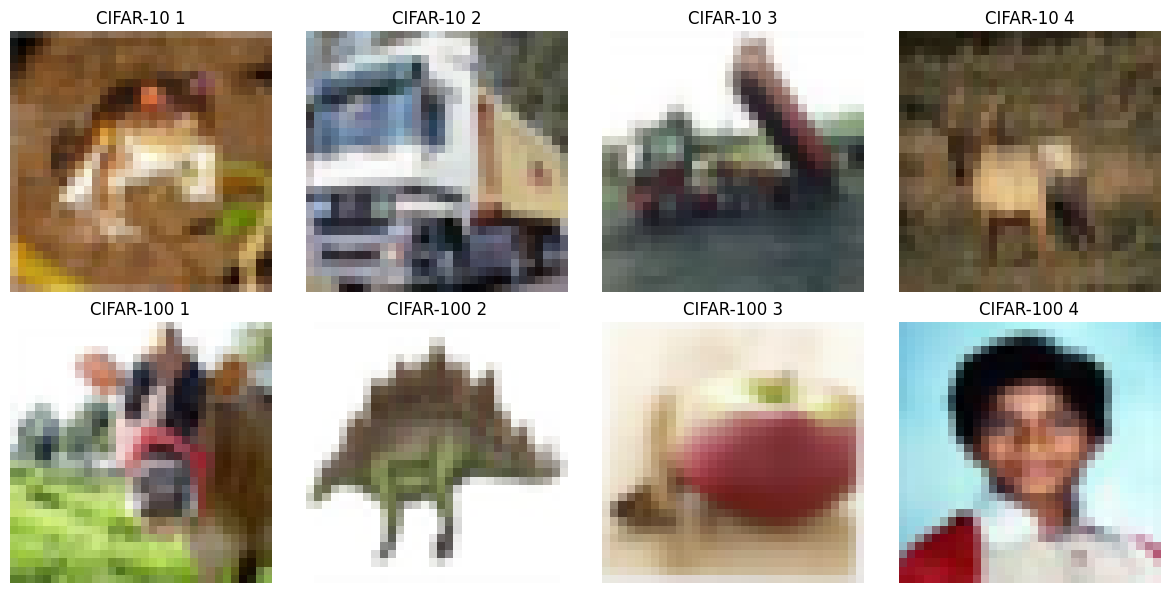

In [3]:
# helper to unnormalize and show a single tensor image on an axis
def imshow_tensor(img, ax):
    # img: torch.Tensor with shape (C, H, W) normalized with mean=0.5,std=0.5
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

# Create a 2x4 grid: first row CIFAR-10, second row CIFAR-100
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    cifar_10_img, _ = cifar_10_trainset[i]
    cifar_100_img, _ = cifar_100_trainset[i]
    imshow_tensor(cifar_10_img, axes[0, i])
    axes[0, i].set_title(f"CIFAR-10 {i+1}")
    imshow_tensor(cifar_100_img, axes[1, i])
    axes[1, i].set_title(f"CIFAR-100 {i+1}")

plt.tight_layout()
plt.show()

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1) # 16x16x16
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1) # 16x16x16
        self.conv3 = nn.Conv2d(16, 16, 3, stride=1, padding=1) # 16x16x16
        self.conv4 = nn.Conv2d(16, 16, 3, stride=1, padding=1) # 16x16x16
        self.conv5 = nn.Conv2d(16, 32, 3, stride=2, padding=1) # 32x8x8
        self.conv6 = nn.Conv2d(32, 32, 3, stride=1, padding=1) # 32x8x8
        self.conv7 = nn.Conv2d(32, 32, 3, stride=1, padding=1) # 32x8x8
        self.conv8 = nn.Conv2d(32, 32, 3, stride=1, padding=1) # 32x8x8
        self.conv9 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 64x4x4
        
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.batch_norm4 = nn.BatchNorm2d(16)
        self.batch_norm5 = nn.BatchNorm2d(32)
        self.batch_norm6 = nn.BatchNorm2d(32)
        self.batch_norm7 = nn.BatchNorm2d(32)
        self.batch_norm8 = nn.BatchNorm2d(32)
        self.batch_norm9 = nn.BatchNorm2d(64)
        
        
        self.fc_mu = nn.Linear(64*4*4, latent_dim)
        self.fc_logvar = nn.Linear(64*4*4, latent_dim)

    def forward(self, x):
        x = F.gelu(self.batch_norm1(self.conv1(x)))
        x = F.gelu(self.batch_norm2(self.conv2(x) + x))
        x = F.gelu(self.batch_norm3(self.conv3(x) + x))
        x = F.gelu(self.batch_norm4(self.conv4(x) + x))
        x = F.gelu(self.batch_norm5(self.conv5(x)))
        x = F.gelu(self.batch_norm6(self.conv6(x) + x))
        x = F.gelu(self.batch_norm7(self.conv7(x) + x))
        x = F.gelu(self.batch_norm8(self.conv8(x) + x))
        x = F.gelu(self.batch_norm9(self.conv9(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(latent_dim, 64*4*4)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1) # 32x8x8
        self.deconv2 = nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1) # 32x8x8
        self.deconv3 = nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1) # 32x8x8
        self.deconv4 = nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1) # 32x8x8
        self.deconv5 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1) # 16x16x16
        self.deconv6 = nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1) # 16x16x16
        self.deconv7 = nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1) # 16x16x16
        self.deconv8 = nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1) # 16x16x16
        self.deconv9 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1) # 3x32x32
        
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.batch_norm5 = nn.BatchNorm2d(16)
        self.batch_norm6 = nn.BatchNorm2d(16)
        self.batch_norm7 = nn.BatchNorm2d(16)
        self.batch_norm8 = nn.BatchNorm2d(16)

    def forward(self, z):
        x = F.gelu(self.fc(z))
        x = x.view(x.size(0), 64, 4, 4)
        x = F.gelu(self.batch_norm1(self.deconv1(x)))
        x = F.gelu(self.batch_norm2(self.deconv2(x) + x))
        x = F.gelu(self.batch_norm3(self.deconv3(x) + x))
        x = F.gelu(self.batch_norm4(self.deconv4(x) + x))
        x = F.gelu(self.batch_norm5(self.deconv5(x)))
        x = F.gelu(self.batch_norm6(self.deconv6(x) + x))
        x = F.gelu(self.batch_norm7(self.deconv7(x) + x))
        x = F.gelu(self.batch_norm8(self.deconv8(x) + x))
        x = F.tanh(self.deconv9(x))
        return x
    
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence, recon_loss, kl_divergence

In [6]:
device = torch.device('mps')
learning_rate = 1e-3
lr_scheduler_step_size = 30
lr_scheduler_gamma = 0.1
warmup_milestone = 5
num_epochs = 100
batch_size = 256
latent_dim = 128
plot_every = 5

In [7]:
dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.ConcatDataset([
        cifar_10_trainset,
        cifar_10_testset,
    ]), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2, 
    persistent_workers=True,
    prefetch_factor=2,
)

vae = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, 
    schedulers=[
        torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=warmup_milestone), 
        torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
    ], 
    milestones=[warmup_milestone], 
)

# Training loop

Epoch 1/100:   0%|          | 0/235 [00:03<?, ?it/s]

Epoch 1/100 | Loss: 850.0125 | Recon: 831.6144 | KL: 18.3980


Epoch 2/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/100 | Loss: 684.8293 | Recon: 670.7316 | KL: 14.0977


Epoch 3/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/100 | Loss: 430.4415 | Recon: 394.5661 | KL: 35.8754


Epoch 4/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/100 | Loss: 364.2735 | Recon: 322.0001 | KL: 42.2735


Epoch 5/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/100 | Loss: 336.0617 | Recon: 292.1276 | KL: 43.9341


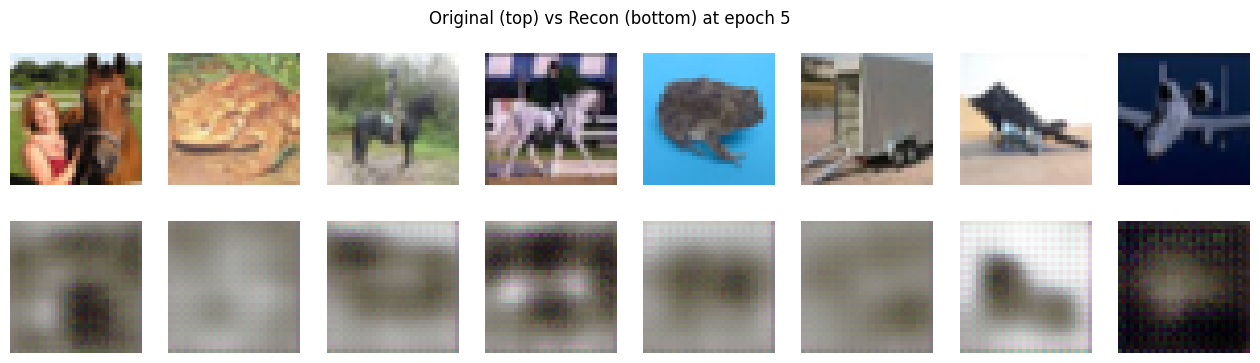

Epoch 6/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/100 | Loss: 292.8897 | Recon: 248.3816 | KL: 44.5081


Epoch 7/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/100 | Loss: 262.0951 | Recon: 217.8197 | KL: 44.2755


Epoch 8/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/100 | Loss: 240.9181 | Recon: 193.9217 | KL: 46.9965


Epoch 9/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/100 | Loss: 219.0034 | Recon: 169.1162 | KL: 49.8873


Epoch 10/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/100 | Loss: 211.9993 | Recon: 160.7282 | KL: 51.2711


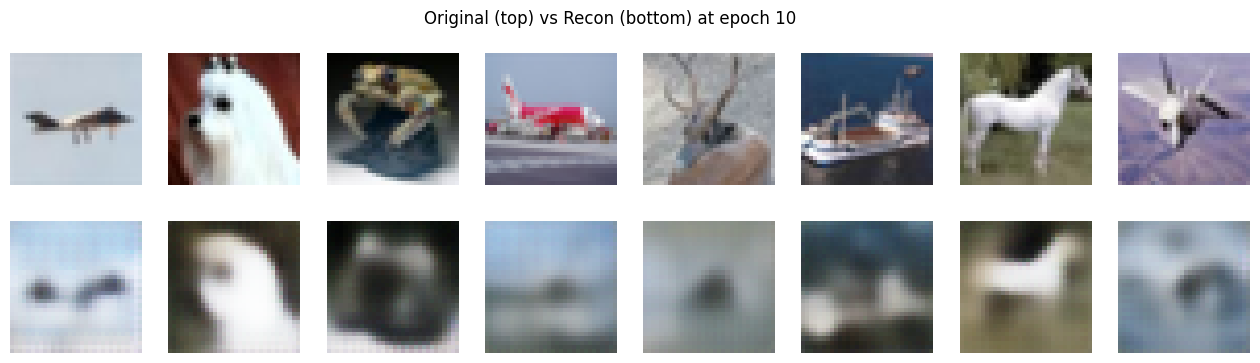

Epoch 11/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/100 | Loss: 208.0346 | Recon: 155.8608 | KL: 52.1737


Epoch 12/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/100 | Loss: 205.5308 | Recon: 152.7433 | KL: 52.7875


Epoch 13/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/100 | Loss: 203.4351 | Recon: 150.0987 | KL: 53.3364


Epoch 14/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/100 | Loss: 201.6157 | Recon: 147.7541 | KL: 53.8616


Epoch 15/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/100 | Loss: 199.7791 | Recon: 145.2692 | KL: 54.5100


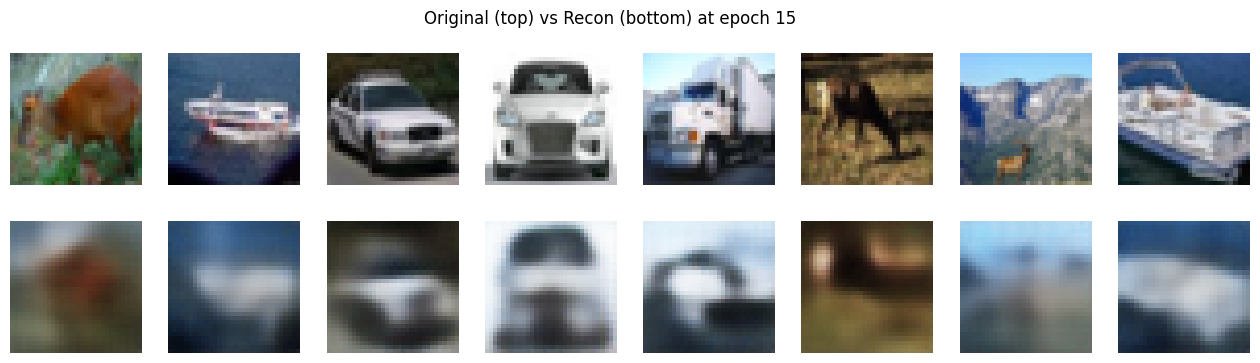

Epoch 16/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/100 | Loss: 198.8109 | Recon: 143.4677 | KL: 55.3432


Epoch 17/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/100 | Loss: 197.4199 | Recon: 141.5180 | KL: 55.9019


Epoch 18/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/100 | Loss: 196.5635 | Recon: 140.1974 | KL: 56.3662


Epoch 19/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/100 | Loss: 195.5605 | Recon: 138.6494 | KL: 56.9111


Epoch 20/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/100 | Loss: 194.6759 | Recon: 137.4096 | KL: 57.2662


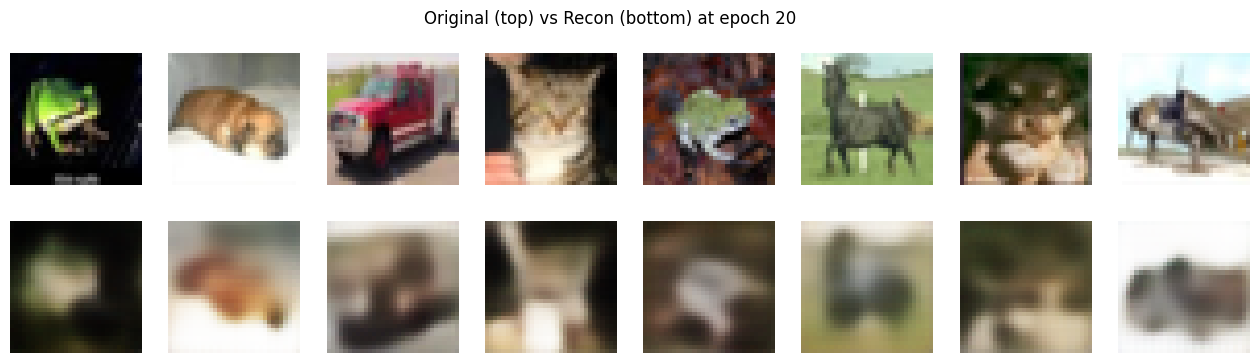

Epoch 21/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/100 | Loss: 193.1481 | Recon: 135.3418 | KL: 57.8062


Epoch 22/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/100 | Loss: 192.5503 | Recon: 134.2763 | KL: 58.2740


Epoch 23/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/100 | Loss: 191.8576 | Recon: 133.1993 | KL: 58.6583


Epoch 24/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/100 | Loss: 190.8275 | Recon: 131.8196 | KL: 59.0079


Epoch 25/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/100 | Loss: 190.5287 | Recon: 131.2998 | KL: 59.2289


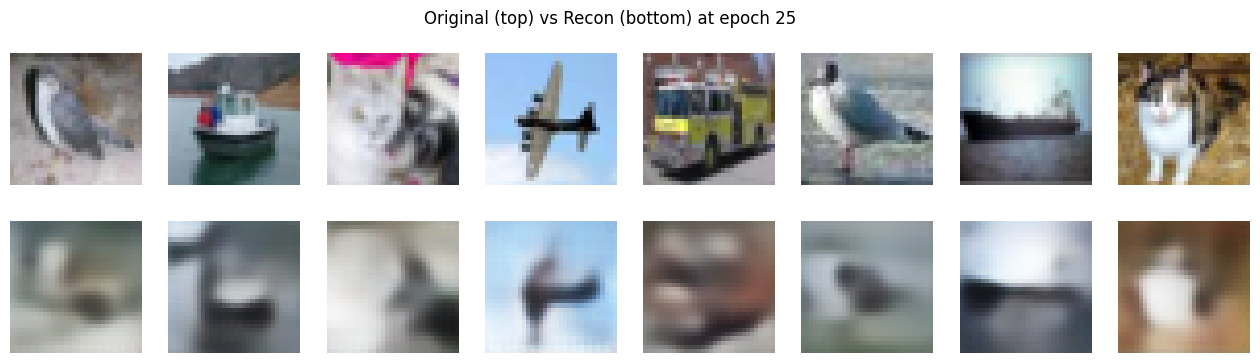

Epoch 26/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/100 | Loss: 189.7865 | Recon: 130.2658 | KL: 59.5207


Epoch 27/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/100 | Loss: 189.1208 | Recon: 129.3225 | KL: 59.7984


Epoch 28/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/100 | Loss: 188.6238 | Recon: 128.5857 | KL: 60.0381


Epoch 29/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/100 | Loss: 188.4296 | Recon: 128.0628 | KL: 60.3668


Epoch 30/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/100 | Loss: 187.5050 | Recon: 126.9641 | KL: 60.5409


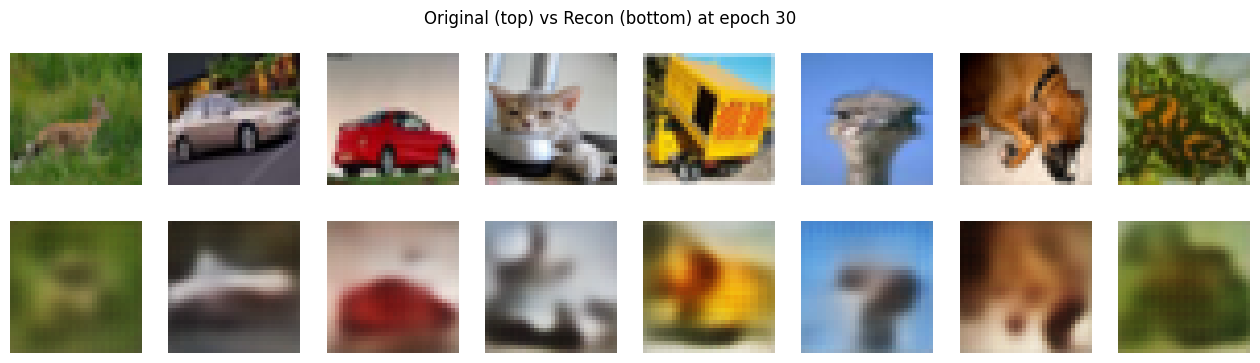

Epoch 31/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/100 | Loss: 187.3620 | Recon: 126.5734 | KL: 60.7886


Epoch 32/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/100 | Loss: 187.0778 | Recon: 126.1362 | KL: 60.9416


Epoch 33/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/100 | Loss: 186.7489 | Recon: 125.6386 | KL: 61.1103


Epoch 34/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/100 | Loss: 186.5318 | Recon: 125.2251 | KL: 61.3067


Epoch 35/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/100 | Loss: 186.1816 | Recon: 124.6345 | KL: 61.5471


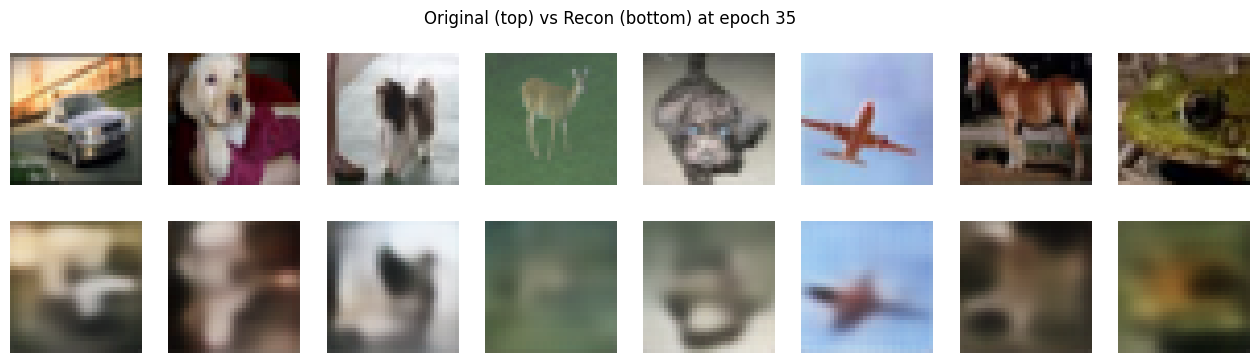

Epoch 36/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/100 | Loss: 183.7375 | Recon: 122.1457 | KL: 61.5918


Epoch 37/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/100 | Loss: 183.1365 | Recon: 121.4002 | KL: 61.7363


Epoch 38/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/100 | Loss: 182.8615 | Recon: 121.0124 | KL: 61.8492


Epoch 39/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/100 | Loss: 183.0303 | Recon: 121.1573 | KL: 61.8730


Epoch 40/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/100 | Loss: 182.7539 | Recon: 120.8119 | KL: 61.9419


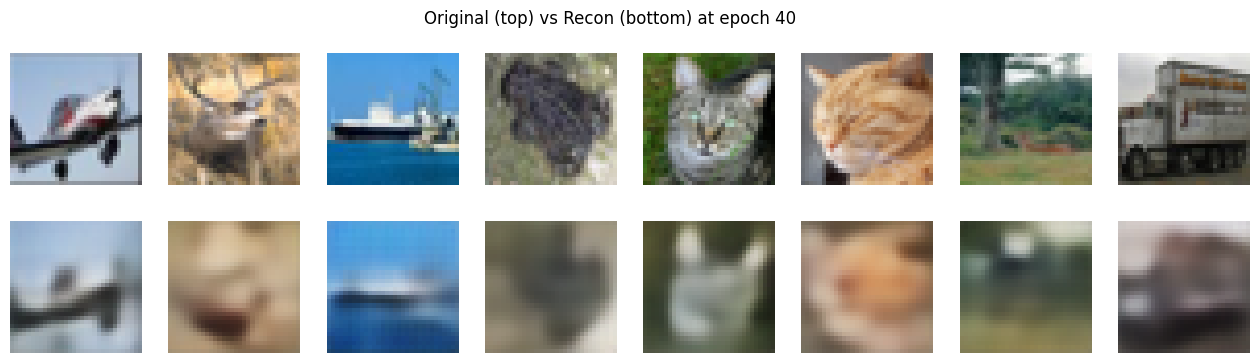

Epoch 41/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/100 | Loss: 182.8655 | Recon: 120.9175 | KL: 61.9480


Epoch 42/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/100 | Loss: 182.8103 | Recon: 120.7882 | KL: 62.0221


Epoch 43/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/100 | Loss: 182.6393 | Recon: 120.6940 | KL: 61.9453


Epoch 44/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/100 | Loss: 182.6335 | Recon: 120.6448 | KL: 61.9887


Epoch 45/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/100 | Loss: 182.6740 | Recon: 120.5886 | KL: 62.0853


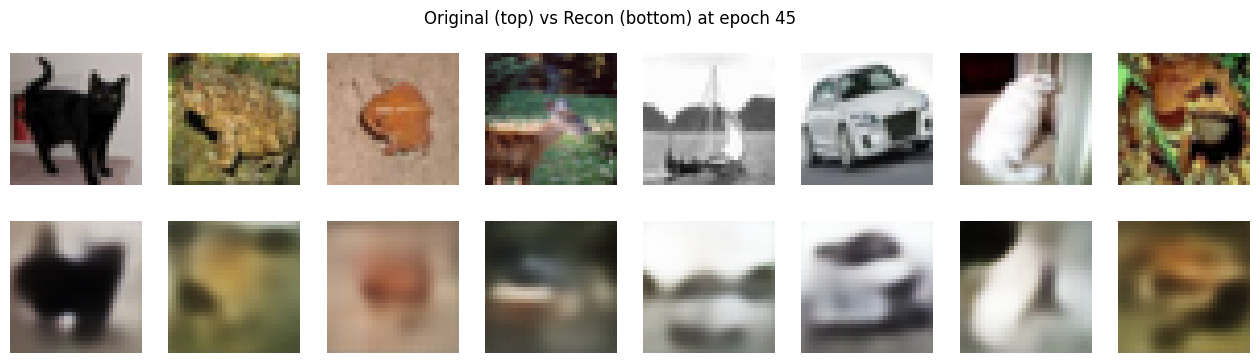

Epoch 46/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/100 | Loss: 182.4454 | Recon: 120.3729 | KL: 62.0725


Epoch 47/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/100 | Loss: 182.4113 | Recon: 120.3265 | KL: 62.0849


Epoch 48/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/100 | Loss: 182.3794 | Recon: 120.1808 | KL: 62.1986


Epoch 49/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/100 | Loss: 182.3291 | Recon: 120.2534 | KL: 62.0756


Epoch 50/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/100 | Loss: 182.3132 | Recon: 120.0793 | KL: 62.2339


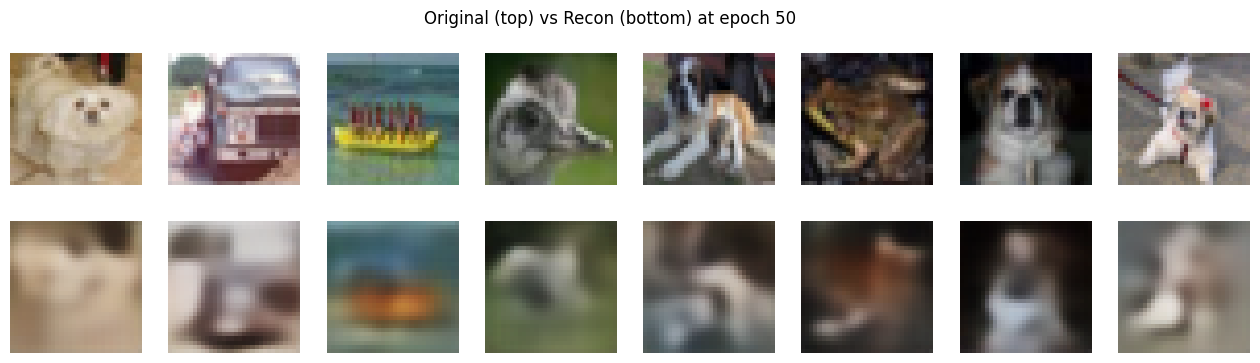

Epoch 51/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/100 | Loss: 182.3490 | Recon: 120.1686 | KL: 62.1804


Epoch 52/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/100 | Loss: 182.0173 | Recon: 119.8416 | KL: 62.1757


Epoch 53/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/100 | Loss: 182.1242 | Recon: 119.8404 | KL: 62.2838


Epoch 54/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/100 | Loss: 182.1160 | Recon: 119.8707 | KL: 62.2453


Epoch 55/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/100 | Loss: 182.1357 | Recon: 119.8445 | KL: 62.2912


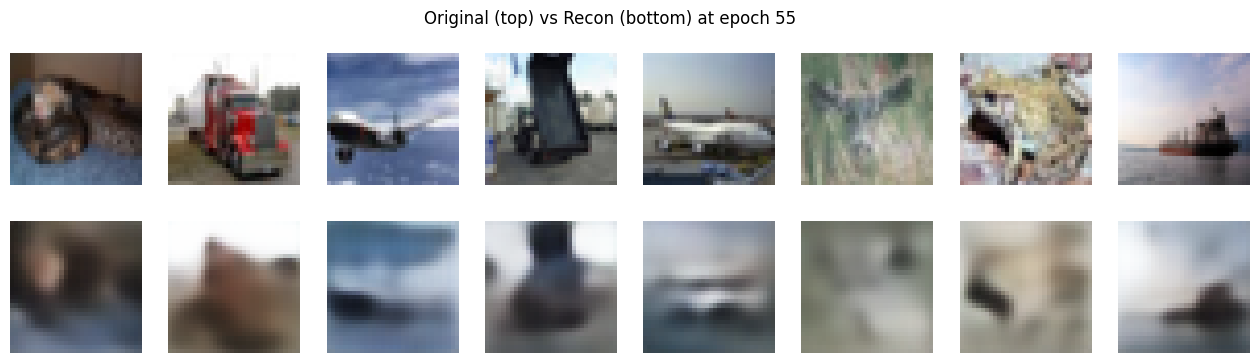

Epoch 56/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/100 | Loss: 182.0747 | Recon: 119.7712 | KL: 62.3034


Epoch 57/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/100 | Loss: 181.9047 | Recon: 119.5850 | KL: 62.3197


Epoch 58/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/100 | Loss: 181.9717 | Recon: 119.6667 | KL: 62.3050


Epoch 59/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/100 | Loss: 181.9605 | Recon: 119.6099 | KL: 62.3506


Epoch 60/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/100 | Loss: 181.9992 | Recon: 119.5562 | KL: 62.4430


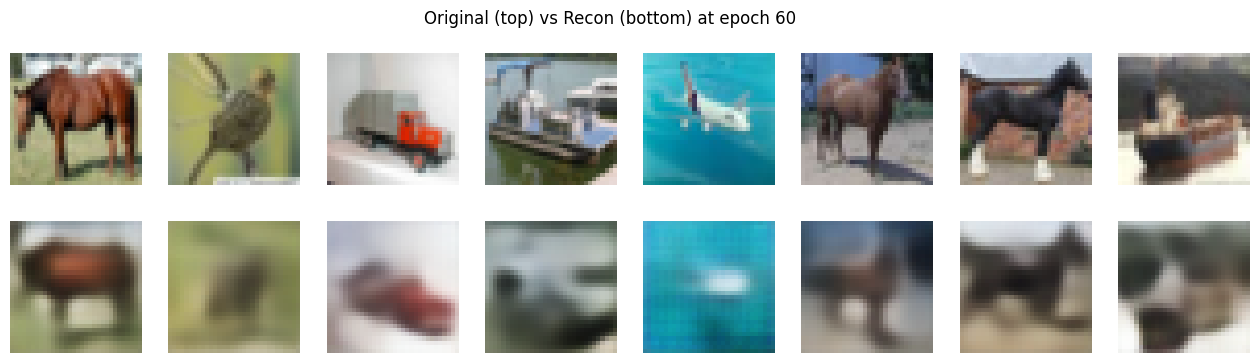

Epoch 61/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 61/100 | Loss: 181.7752 | Recon: 119.4276 | KL: 62.3476


Epoch 62/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 62/100 | Loss: 181.8438 | Recon: 119.3748 | KL: 62.4690


Epoch 63/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 63/100 | Loss: 181.8639 | Recon: 119.4183 | KL: 62.4456


Epoch 64/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 64/100 | Loss: 181.7660 | Recon: 119.2600 | KL: 62.5059


Epoch 65/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 65/100 | Loss: 181.7512 | Recon: 119.2265 | KL: 62.5247


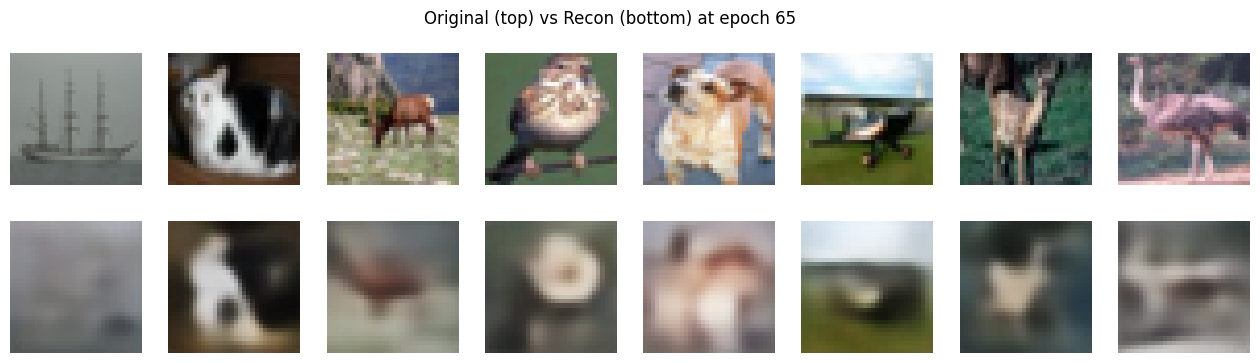

Epoch 66/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 66/100 | Loss: 181.3077 | Recon: 118.9266 | KL: 62.3811


Epoch 67/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 67/100 | Loss: 181.3300 | Recon: 118.8689 | KL: 62.4611


Epoch 68/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 68/100 | Loss: 181.3171 | Recon: 118.7683 | KL: 62.5488


Epoch 69/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 69/100 | Loss: 181.3545 | Recon: 118.8242 | KL: 62.5303


Epoch 70/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 70/100 | Loss: 181.2742 | Recon: 118.7353 | KL: 62.5389


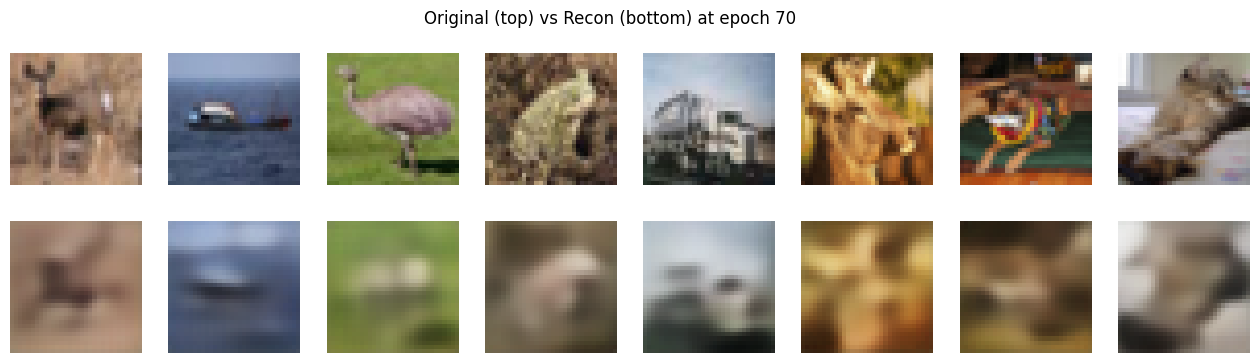

Epoch 71/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 71/100 | Loss: 181.3460 | Recon: 118.8653 | KL: 62.4807


Epoch 72/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 72/100 | Loss: 181.3339 | Recon: 118.7574 | KL: 62.5765


Epoch 73/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 73/100 | Loss: 181.2814 | Recon: 118.7583 | KL: 62.5231


Epoch 74/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 74/100 | Loss: 181.2328 | Recon: 118.6986 | KL: 62.5341


Epoch 75/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 75/100 | Loss: 181.1299 | Recon: 118.6206 | KL: 62.5093


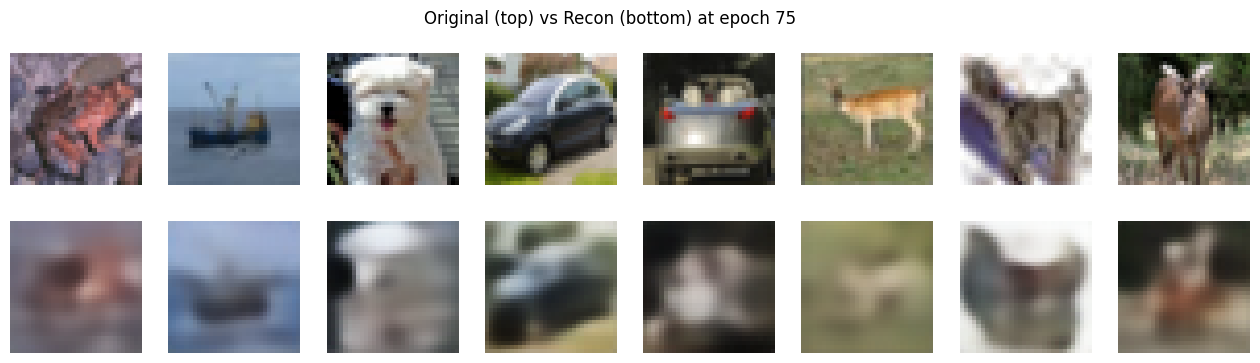

Epoch 76/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 76/100 | Loss: 181.3243 | Recon: 118.7471 | KL: 62.5772


Epoch 77/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 77/100 | Loss: 181.1174 | Recon: 118.5850 | KL: 62.5324


Epoch 78/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 78/100 | Loss: 181.2388 | Recon: 118.6413 | KL: 62.5975


Epoch 79/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 79/100 | Loss: 181.1813 | Recon: 118.6160 | KL: 62.5652


Epoch 80/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 80/100 | Loss: 181.2315 | Recon: 118.6647 | KL: 62.5668


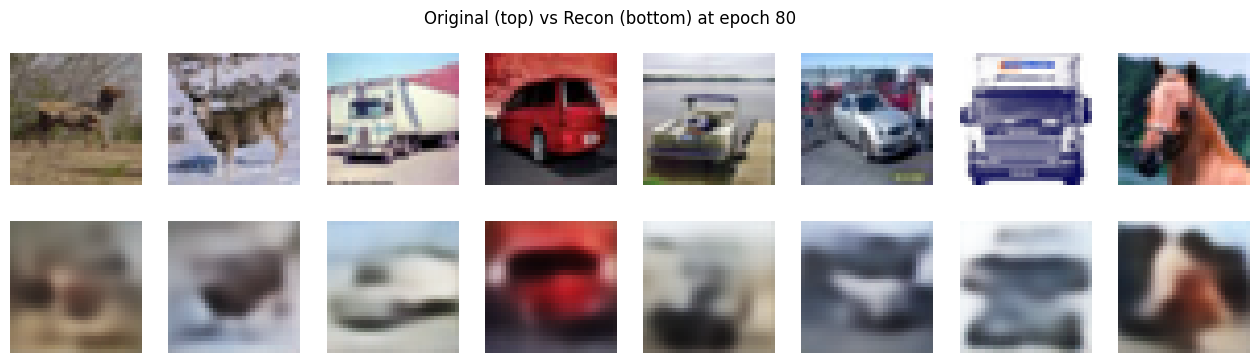

Epoch 81/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 81/100 | Loss: 181.2037 | Recon: 118.6047 | KL: 62.5991


Epoch 82/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 82/100 | Loss: 181.2392 | Recon: 118.6726 | KL: 62.5666


Epoch 83/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 83/100 | Loss: 181.1320 | Recon: 118.5196 | KL: 62.6124


Epoch 84/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 84/100 | Loss: 181.2237 | Recon: 118.6574 | KL: 62.5662


Epoch 85/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 85/100 | Loss: 181.2688 | Recon: 118.7192 | KL: 62.5496


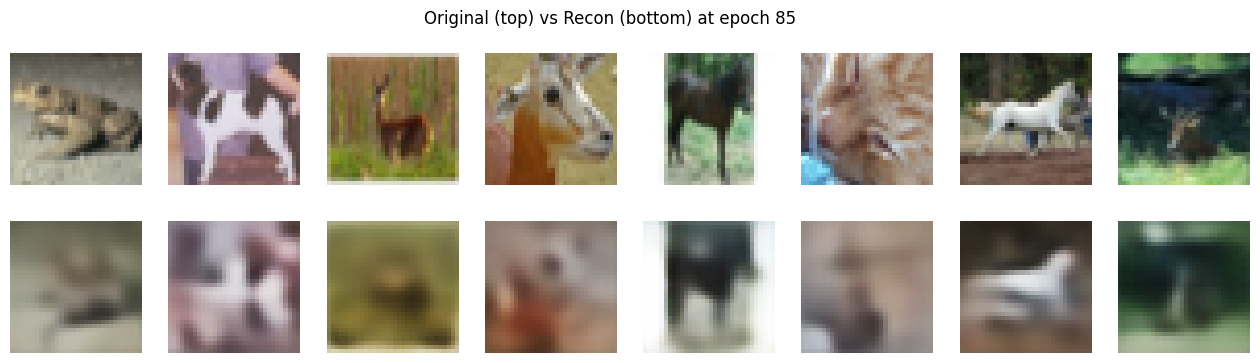

Epoch 86/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 86/100 | Loss: 181.1947 | Recon: 118.6170 | KL: 62.5777


Epoch 87/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 87/100 | Loss: 181.1025 | Recon: 118.5388 | KL: 62.5637


Epoch 88/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 88/100 | Loss: 181.2626 | Recon: 118.6618 | KL: 62.6008


Epoch 89/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 89/100 | Loss: 181.1645 | Recon: 118.5761 | KL: 62.5884


Epoch 90/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 90/100 | Loss: 181.1812 | Recon: 118.5833 | KL: 62.5979


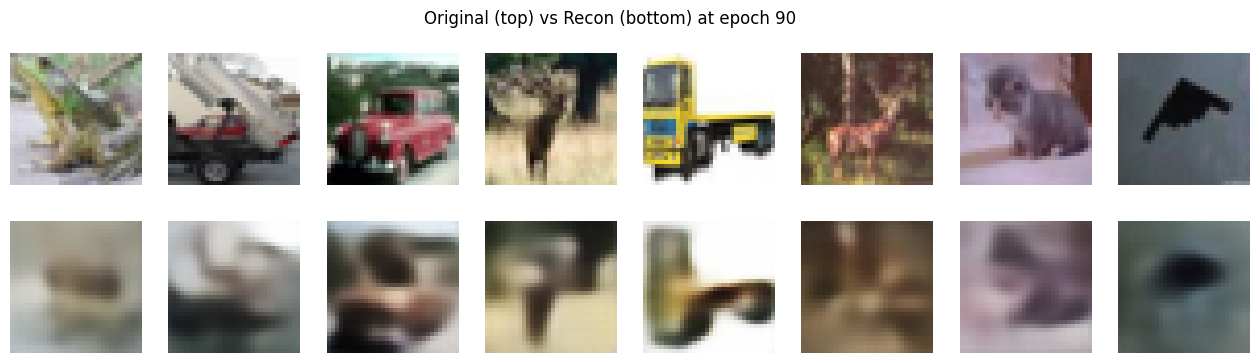

Epoch 91/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 91/100 | Loss: 181.2632 | Recon: 118.6416 | KL: 62.6216


Epoch 92/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 92/100 | Loss: 181.0840 | Recon: 118.4778 | KL: 62.6063


Epoch 93/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 93/100 | Loss: 181.1186 | Recon: 118.4804 | KL: 62.6382


Epoch 94/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 94/100 | Loss: 181.1667 | Recon: 118.5955 | KL: 62.5712


Epoch 95/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 95/100 | Loss: 181.1937 | Recon: 118.5799 | KL: 62.6139


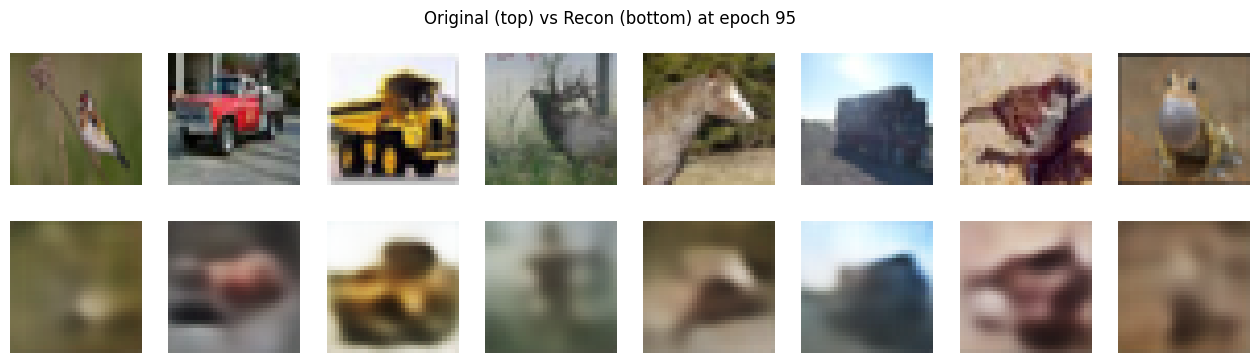

Epoch 96/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 96/100 | Loss: 181.1624 | Recon: 118.5588 | KL: 62.6036


Epoch 97/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 97/100 | Loss: 181.0683 | Recon: 118.4885 | KL: 62.5799


Epoch 98/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 98/100 | Loss: 181.0689 | Recon: 118.4678 | KL: 62.6011


Epoch 99/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 99/100 | Loss: 181.0808 | Recon: 118.4794 | KL: 62.6014


Epoch 100/100:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 100/100 | Loss: 181.0431 | Recon: 118.4513 | KL: 62.5918


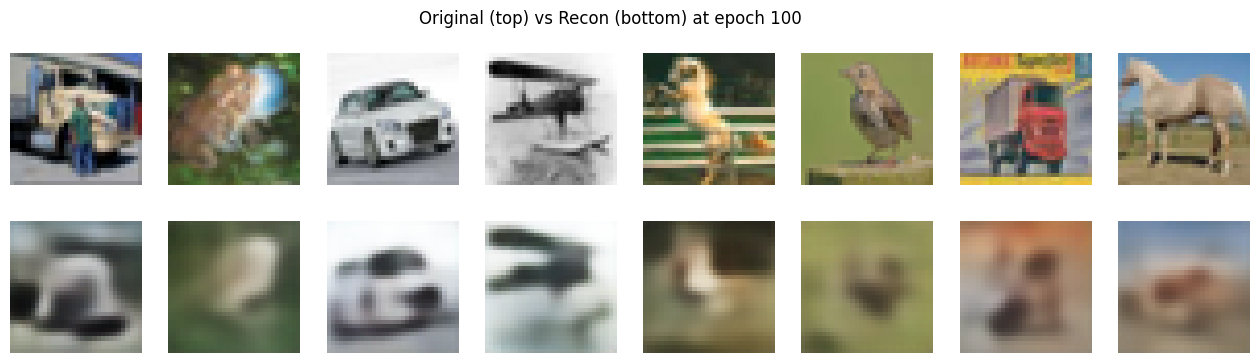

In [8]:
epoch_losses = []
epoch_recons = []
epoch_kls = []

for epoch in range(0, num_epochs):
    vae.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device, non_blocking=True)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss, recon_loss, kl = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl.item()
    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon = total_recon / len(dataloader.dataset)
    avg_kl = total_kl / len(dataloader.dataset)
    epoch_losses.append(avg_loss)
    epoch_recons.append(avg_recon)
    epoch_kls.append(avg_kl)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

    if (epoch + 1) % plot_every == 0:
        vae.eval()
        with torch.no_grad():
            sample_images, _ = next(iter(dataloader))
            sample_images = sample_images.to(device)
            recon_images, _, _ = vae(sample_images)
        sample_images = sample_images[:8].cpu()
        recon_images = recon_images[:8].cpu()
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            imshow_tensor(sample_images[i], axes[0, i])
            imshow_tensor(recon_images[i], axes[1, i])
        plt.suptitle(f"Original (top) vs Recon (bottom) at epoch {epoch+1}")
        plt.show()
    
    scheduler.step()

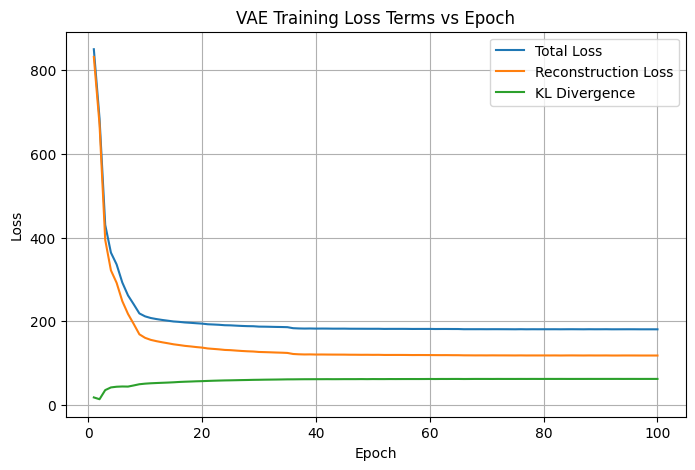

In [9]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, epoch_losses, label='Total Loss')
plt.plot(epochs, epoch_recons, label='Reconstruction Loss')
plt.plot(epochs, epoch_kls, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss Terms vs Epoch')
plt.legend()
plt.grid(True)
plt.show()